# Stabilization policy

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["NUMBA_PARFOR_MAX_TUPLE_SIZE"] = "200"
import sys 
sys.path.insert(0, './Main')

import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
from copy import deepcopy
import matplotlib.pyplot as plt   

from matplotlib.ticker import FormatStrFormatter
import matplotlib
execfile("figsettings.py") # Work for now, but bad practice 

from IHANKModel import HANKModelClass
import utils
import figs
import GetForeignEcon
import sol_helpers
import numba as nb
nb.set_num_threads(6)

## Shocks and policies

In [2]:
def CumMult(model,var,r=0,T=20,sign=1):
    scale = model.par.scale 
    if np.isclose(getattr(model.ss,var),0):
        dX = (getattr(model.path,var)[0,:] - getattr(model.ss,var))*scale
    else:
        dX = (getattr(model.path,var)[0,:] - getattr(model.ss,var))*scale/getattr(model.ss,var)
    return 100*np.sum(dX[:T]) 

In [3]:
shocklist = ['ForeignDemand', 'eps_beta', 'UniformT_exo', 'G_exo', 'di']
exch_regime = ['floating', 'fixed']

# Various different calibrations 
#model.par.MonPol = 'Taylor'
#model.par.MonPol = 'ZLB'
# Real income channel?
#model.par.gamma = 0.35
#model.par.eta = 0.6
#model.par.HH_importshare = 1.0
#model.par.HH_type = 'RA-IM'
#model.par.X_expshare = np.array([0.0, 0.0])

def shocks_and_pols(upars={}, shocklist=['ForeignDemand', 'eps_beta', 'UniformT_exo', 'G_exo', 'di'], exch_regime=['floating', 'fixed'], foreign_persistence=None):
    
    model = HANKModelClass()
    model.par.debt_rule = False   
    for par in upars:
        setattr(model.par, par, upars[par])
        
    model.find_ss()    
    
    models = {}
    compiled = False
    for regime in exch_regime:
        print(f'regime = {regime}')
        models[regime] = {}
        if regime == 'floating':
            model.par.floating = True
            floating=True
        else:
            model.par.floating = False
            floating=False
            shocklist = [x for x in shocklist if x != 'di']
            shocklist += ['ND']
            shocklist += ['FD']
            

        model.compute_jacs(do_print=False,skip_shocks=True)

        for i,shock in enumerate(shocklist):
            models[shock] = {}
            if shock == 'ForeignDemand':
                model_foreign = GetForeignEcon.get_foreign_econ(persistence=foreign_persistence)
                GetForeignEcon.create_foreign_shock(model, model_foreign)
            else:
                utils.Create_shock(shock, model, 0.0001, absval=True)
            model.transition_path(do_print=False)
            if shock == 'ForeignDemand' or shock == 'eps_beta':
                utils.scaleshock('C', model,  size=-0.01, cumeffect=True, Nq=20)
            else:
                utils.scaleshock('C', model,  size=0.01, cumeffect=True, Nq=20)
            models[regime][shock] = deepcopy(model)
    del model
    print(f'Finished!')
    return models 

models = shocks_and_pols()

regime = floating
regime = fixed
Finished!


### Terms of trade and real exchange rate movements

regime = floating


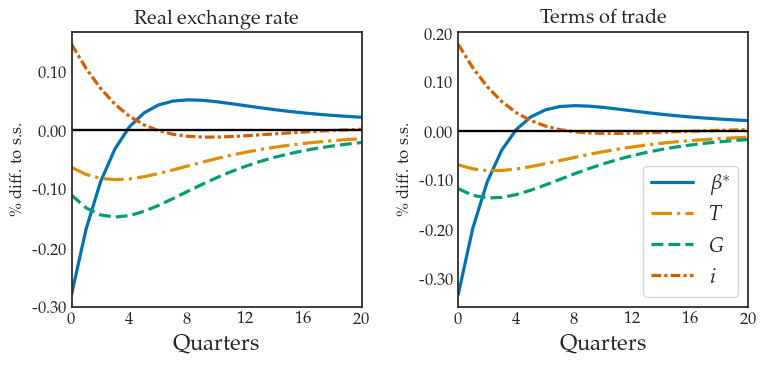


regime = fixed


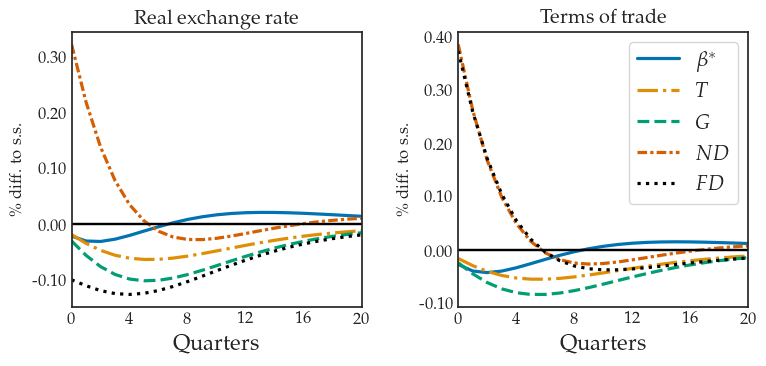

In [4]:
T_max = 21 

for regime in exch_regime: 
    print(f'regime = {regime}')
    models_ = models[regime]
    paths = ['Q','ToT']
    pathlabels = ['Real exchange rate', 'Terms of trade']
    pctp = ['r', 'piF', 'pi', 'piNT', 'piH', 'Dompi', 'di', 'NFA']
    abs_value = None # ['GDP', 'G']
    colors = ['C0', 'C1', 'C2', 'C3', 'black']
    ldash = ['-', '-.', '--', (0, (3, 1, 1, 1)), ':']

    if regime == 'floating':
        modellist = [models_['ForeignDemand'], models_['UniformT_exo'], models_['G_exo'], models_['di']]
        labels =  [r'$\beta^*$', r'$T$', r'$G$', r'$i$']
    else:
        modellist = [models_['ForeignDemand'], models_['UniformT_exo'], models_['G_exo'], models_['ND'], models_['FD']]
        labels =  [r'$\beta^*$', r'$T$', r'$G$', r'$ND$', r'$FD$']

    fig = figs.show_IRFs_new(models=modellist, paths=paths,labels=labels, ldash=ldash,
                        T_max=T_max, do_sumplot=False, scale=True, shocktitle=None, maxrow=3, pathlabels=pathlabels,
                        colors=colors, lwidth=2.3, pctp=pctp, palette='colorblind', figsize=[4, 4], legend_window=1)  

    if regime == 'floating':
        fig.savefig(f'plots\policy\policy_Q_ToT_floating.pdf')
    else:
        fig.savefig(f'plots\policy\policy_Q_ToT_fixed.pdf')

## Tables 

In [5]:
def CumMult(model,var,r=0,T=20,sign=1):
    scale = model.par.scale 
    if np.isclose(getattr(model.ss,var),0):
        dX = (getattr(model.path,var)[0,:] - getattr(model.ss,var))*scale
    else:
        dX = (getattr(model.path,var)[0,:] - getattr(model.ss,var))*scale/getattr(model.ss,var)
    return 100*np.sum(dX[:T]) 

### Consumption

In [6]:
def get_c_resps(models, TNT_vars=['C_T_hh', 'C_NT_hh']):
    
    shock_descs = {'ForeignDemand' : r'Foreign demand, $\beta^*$', 'eps_beta' : r'Domestic demand, $\beta$',  'UniformT_exo' : 'Public transfers, $T$',
                   'G_exo' : 'Public spending, $G$', 'di' : 'Monetary policy, $i$', 'ND' : 'Nominal devaluation', 'FD' : 'Fiscal devaluation'}     
    
    shock_descs1 = {}
    for shock in shock_descs:
        shock_descs1[shock] = {}
        shock_descs1[shock]['name'] =  shock_descs[shock]
    
    sign=1
    hori = 20 
    multi_dict_simple = {}
    for regime in exch_regime: 
        multi_dict_simple[regime] = {}
        for shock in models[regime]:
            multi_dict_simple[regime][shock] = {}
            multi_dict_simple[regime][shock]['C'] = CumMult(models[regime][shock],'C', T=hori,sign=sign)
            multi_dict_simple[regime][shock][TNT_vars[0]] = CumMult(models[regime][shock],TNT_vars[0], T=hori,sign=sign)
            multi_dict_simple[regime][shock][TNT_vars[1]] = CumMult(models[regime][shock],TNT_vars[1], T=hori,sign=sign)
            multi_dict_simple[regime][shock]['CT_2_CNT'] = CumMult(models[regime][shock],TNT_vars[0], T=hori,sign=sign)/CumMult(models[regime][shock],TNT_vars[1], T=hori,sign=sign)

    
    temp_df = pd.DataFrame(shock_descs1).append(pd.DataFrame(multi_dict_simple['floating']))
    temp_df = pd.DataFrame(temp_df).append(pd.DataFrame(multi_dict_simple['fixed']))
    temp_df = temp_df.replace(np.NaN, '-')
    tex_table = temp_df.round(2).T.to_latex(index=False, escape=False)
    print(tex_table)
    return tex_table

tex_table = get_c_resps(models)

with open("tables/policy_tabel_main_cons.txt", "w") as text_file:
    text_file.write(tex_table[150:884])

\begin{tabular}{lllllllll}
\toprule
                     name &     C & C_T_hh & C_NT_hh & CT_2_CNT &     C & C_T_hh & C_NT_hh & CT_2_CNT \\
\midrule
Foreign demand, $\beta^*$ & -1.00 &  -1.23 &   -0.90 &     1.37 & -1.00 &  -0.95 &   -1.02 &     0.92 \\
 Domestic demand, $\beta$ & -1.00 &  -0.69 &   -1.14 &     0.60 & -1.00 &  -0.71 &   -1.13 &     0.63 \\
    Public transfers, $T$ &  1.00 &   0.57 &    1.19 &     0.48 &  1.00 &   0.64 &    1.16 &     0.55 \\
     Public spending, $G$ &  1.00 &   0.01 &    1.44 &     0.01 &  1.00 &   0.23 &    1.34 &     0.17 \\
     Monetary policy, $i$ &  1.00 &   0.95 &    1.02 &     0.93 &     - &      - &       - &        - \\
      Nominal devaluation &     - &      - &       - &        - &  1.00 &   1.05 &    0.98 &     1.07 \\
       Fiscal devaluation &     - &      - &       - &        - &  1.00 &   1.03 &    0.99 &     1.04 \\
\bottomrule
\end{tabular}



### Income

In [7]:
tex_table_inc = get_c_resps(models, TNT_vars=['wnT', 'wnNT'])
with open("tables/policy_tabel_main_income.txt", "w") as text_file:
    text_file.write(tex_table_inc[144:836])

\begin{tabular}{lllllllll}
\toprule
                     name &     C &   wnT &  wnNT & CT_2_CNT &     C &   wnT &  wnNT & CT_2_CNT \\
\midrule
Foreign demand, $\beta^*$ & -1.00 & -2.12 & -1.69 &     1.26 & -1.00 & -1.50 & -1.60 &     0.94 \\
 Domestic demand, $\beta$ & -1.00 & -0.32 & -0.90 &     0.35 & -1.00 & -0.36 & -0.90 &     0.40 \\
    Public transfers, $T$ &  1.00 &  0.02 &  0.78 &     0.02 &  1.00 &  0.21 &  0.86 &     0.25 \\
     Public spending, $G$ &  1.00 &  0.46 &  2.29 &     0.20 &  1.00 &  0.66 &  2.08 &     0.32 \\
     Monetary policy, $i$ &  1.00 &  1.40 &  1.49 &     0.94 &     - &     - &     - &        - \\
      Nominal devaluation &     - &     - &     - &        - &  1.00 &  1.52 &  1.42 &     1.07 \\
       Fiscal devaluation &     - &     - &     - &        - &  1.00 &  1.72 &  1.67 &     1.03 \\
\bottomrule
\end{tabular}



## Robustness w.r.t persistence, T and G 

### Persistence 

In [13]:
rho_low = 0.7 
rho_high = 0.9
for rho in ['rho_low','rho_high']:
    if rho == 'rho_low':
        rho_val = rho_low
    elif rho == 'rho_high':
        rho_val = rho_high        
    print(f'### rho = {rho_val} ###')
    upars = {'rho' : rho_val}
    models = shocks_and_pols(upars=upars, foreign_persistence=rho_val)
    textable_rho = get_c_resps(models)
    with open(f"tables/policy_tabel_{rho}.txt", "w") as text_file:
        text_file.write(textable_rho[150:884])

### rho = 0.7 ###
regime = floating
regime = fixed
Finished!
\begin{tabular}{lllllllll}
\toprule
                     name &     C & C_T_hh & C_NT_hh & CT_2_CNT &     C & C_T_hh & C_NT_hh & CT_2_CNT \\
\midrule
Foreign demand, $\beta^*$ & -1.00 &  -1.16 &   -0.93 &     1.26 & -1.00 &  -0.94 &   -1.03 &     0.92 \\
 Domestic demand, $\beta$ & -1.00 &  -0.74 &   -1.12 &     0.66 & -1.00 &  -0.75 &   -1.11 &     0.68 \\
    Public transfers, $T$ &  1.00 &   0.61 &    1.17 &     0.52 &  1.00 &   0.66 &    1.15 &     0.58 \\
     Public spending, $G$ &  1.00 &   0.18 &    1.36 &     0.13 &  1.00 &   0.31 &    1.31 &     0.24 \\
     Monetary policy, $i$ &  1.00 &   0.96 &    1.02 &     0.94 &     - &      - &       - &        - \\
      Nominal devaluation &     - &      - &       - &        - &  1.00 &   1.12 &    0.95 &     1.18 \\
       Fiscal devaluation &     - &      - &       - &        - &  1.00 &   1.06 &    0.97 &     1.09 \\
\bottomrule
\end{tabular}

### rho = 0.9 ###
regime = 

### G 

In [5]:
def single_shock(vary_par, vary_par_vals, shock, exch_regime=['floating', 'fixed']):
    
    model = HANKModelClass()
    model.par.debt_rule = False   

    models = {}
    compiled = False
    for regime in exch_regime:
        print(f'regime = {regime}')
        models[regime] = {}
        if regime == 'floating':
            model.par.floating = True
            floating=True
        else:
            model.par.floating = False
            floating=False
        for par_val in vary_par_vals:
            setattr(model.par, vary_par, par_val)
            model.find_ss()    
            model.compute_jacs(do_print=False,skip_shocks=True)
            utils.Create_shock(shock, model, 0.0001, absval=True)
            model.transition_path(do_print=False)
            utils.scaleshock('C', model,  size=0.01, cumeffect=True, Nq=20)
            models[regime][vary_par + ' = ' + str(par_val)] = deepcopy(model)
    del model
    print(f'Finished!')
    return models 

In [15]:
sGT_vals = [0.1, 0.2, 0.3]
models_vary_G = single_shock(vary_par='sGT', vary_par_vals=sGT_vals, shock='G_exo', exch_regime=['floating', 'fixed'])

regime = floating
regime = fixed
Finished!


In [6]:
def get_c_resps_single_shock(models, vary_par, par_label, vary_par_vals, TNT_vars=['C_T_hh', 'C_NT_hh']):

    shock_descs1 = {}
    for par_val in vary_par_vals:
        templabel = par_label + ' = ' + str(par_val)
        shock_descs1[templabel] = {}
        shock_descs1[templabel]['name'] =  templabel  
       
    sign=1
    hori = 20 
    multi_dict_simple = {}
    for regime in exch_regime: 
        multi_dict_simple[regime] = {}
        for par_val in vary_par_vals:
            temp = vary_par + ' = ' + str(par_val)   
            templabel = par_label + ' = ' + str(par_val)   
            multi_dict_simple[regime][templabel] = {}
            multi_dict_simple[regime][templabel]['C'] = CumMult(models[regime][temp],'C', T=hori,sign=sign)
            multi_dict_simple[regime][templabel][TNT_vars[0]] = CumMult(models[regime][temp],TNT_vars[0], T=hori,sign=sign)
            multi_dict_simple[regime][templabel][TNT_vars[1]] = CumMult(models[regime][temp],TNT_vars[1], T=hori,sign=sign)
            multi_dict_simple[regime][templabel]['CT_2_CNT'] = CumMult(models[regime][temp],TNT_vars[0], T=hori,sign=sign)/CumMult(models[regime][temp],TNT_vars[1], T=hori,sign=sign)

    
    temp_df = pd.DataFrame(shock_descs1).append(pd.DataFrame(multi_dict_simple['floating']))
    temp_df = pd.DataFrame(temp_df).append(pd.DataFrame(multi_dict_simple['fixed']))
    temp_df = temp_df.replace(np.NaN, '-')
    tex_table = temp_df.round(2).T.to_latex(index=False, escape=False)
    print(tex_table)
    return tex_table
    #print(temp_df.round(2).T.to_latex(index=False))
 

In [47]:
tex_table_G = get_c_resps_single_shock(models_vary_G, vary_par='sGT', par_label=r'$s_{T}^{G}$', vary_par_vals=sGT_vals)
with open(f"tables/policy_tabel_G.txt", "w") as text_file:
    text_file.write(tex_table_G[140:424])

\begin{tabular}{lllllllll}
\toprule
             name &    C & C_T_hh & C_NT_hh & CT_2_CNT &    C & C_T_hh & C_NT_hh & CT_2_CNT \\
\midrule
$s_{T}^{G}$ = 0.1 & 1.00 &  -0.12 &    1.50 &    -0.08 & 1.00 &   0.13 &    1.39 &     0.09 \\
$s_{T}^{G}$ = 0.2 & 1.00 &   0.01 &    1.44 &     0.01 & 1.00 &   0.23 &    1.34 &     0.17 \\
$s_{T}^{G}$ = 0.3 & 1.00 &   0.15 &    1.38 &     0.11 & 1.00 &   0.33 &    1.30 &     0.26 \\
\bottomrule
\end{tabular}



### T

In [7]:
sTransferT_vals = [0.4, 0.5, 0.6]
models_vary_T = single_shock(vary_par='sTransferT', vary_par_vals=sTransferT_vals, shock='UniformT_exo', exch_regime=['floating', 'fixed'])

regime = floating
regime = fixed
Finished!


In [12]:
tex_table_T = get_c_resps_single_shock(models_vary_T, vary_par='sTransferT', par_label=r'$s_{T}^{T}$', vary_par_vals=sTransferT_vals)
with open(f"tables/policy_tabel_T.txt", "w") as text_file:
    text_file.write(tex_table_T[140:424])

\begin{tabular}{lllllllll}
\toprule
             name &    C & C_T_hh & C_NT_hh & CT_2_CNT &    C & C_T_hh & C_NT_hh & CT_2_CNT \\
\midrule
$s_{T}^{T}$ = 0.4 & 1.00 &   0.45 &    1.25 &     0.36 & 1.00 &   0.53 &    1.21 &     0.44 \\
$s_{T}^{T}$ = 0.5 & 1.00 &   0.57 &    1.19 &     0.48 & 1.00 &   0.64 &    1.16 &     0.55 \\
$s_{T}^{T}$ = 0.6 & 1.00 &   0.70 &    1.13 &     0.62 & 1.00 &   0.74 &    1.11 &     0.67 \\
\bottomrule
\end{tabular}

